<a href="https://colab.research.google.com/github/SS1031/kaggle-shopee/blob/main/notebooks/experiment002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ipython-autotime
!pip install optuna

In [2]:
%load_ext autotime

time: 90.2 µs (started: 2021-03-21 12:14:09 +00:00)


In [3]:
!nvidia-smi

Sun Mar 21 12:14:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

In [5]:
import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

***********************************************************************
Let us check on those pyarrow and cffi versions...
***********************************************************************

You're don't have pyarrow.
unloaded cffi 1.14.5
loaded cffi 1.14.5
time: 23.7 ms (started: 2021-03-21 12:33:23 +00:00)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 1min 18s (started: 2021-03-21 12:33:23 +00:00)


In [ ]:
!mkdir "/input/"
!cp "/content/drive/MyDrive/kaggle-shopee/shopee-product-matching.zip" "/input/"
!unzip "/input/shopee-product-matching.zip" -d "/input/shopee-product-matching"
!rm -rf "/input/shopee-product-matching.zip"

In [37]:
# Import libraries
import numpy as np, pandas as pd, gc
import cv2, matplotlib.pyplot as plt
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
import optuna
print('RAPIDS',cuml.__version__)
print('TF',tf.__version__)

RAPIDS 0.18.0
TF 2.4.1
time: 4.4 ms (started: 2021-03-21 14:34:02 +00:00)


In [9]:
# RESTRICT TENSORFLOW TO 12GB OF GPU RAM
# SO THAT WE HAVE GPU RAM FOR RAPIDS CUML KNN
LIMIT = 12
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
print('Restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
print('so RAPIDS can use %iGB GPU RAM'%(16-LIMIT))

1 Physical GPUs, 1 Logical GPUs
Restrict TensorFlow to max 12GB GPU RAM
so RAPIDS can use 4GB GPU RAM
time: 12.5 s (started: 2021-03-21 12:36:56 +00:00)


# Load Train Data

`label_group` が ground truth を示している


In [10]:
COMPUTE_CV = True

test = pd.read_csv("../input/shopee-product-matching/test.csv")

train = pd.read_csv('../input/shopee-product-matching/train.csv')

train = pd.read_csv('../input/shopee-product-matching/train.csv')
tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(tmp)
print('train shape is', train.shape )
train.head()

train shape is (34250, 6)


,posting_id,image,image_phash,title,label_group,target
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]"
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,"[train_2288590299, train_3803689425]"
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,"[train_2406599165, train_3342059966]"
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]"


time: 851 ms (started: 2021-03-21 12:37:08 +00:00)


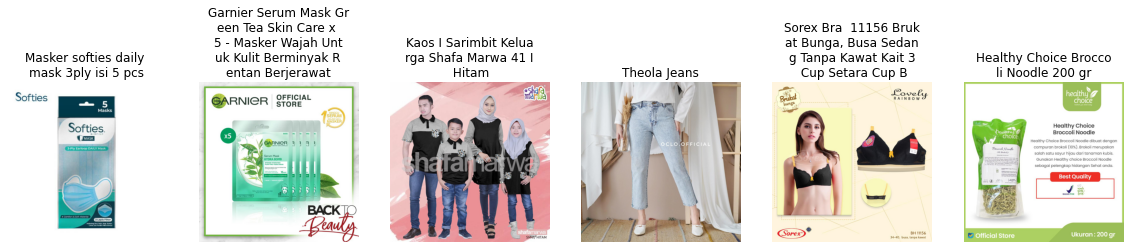

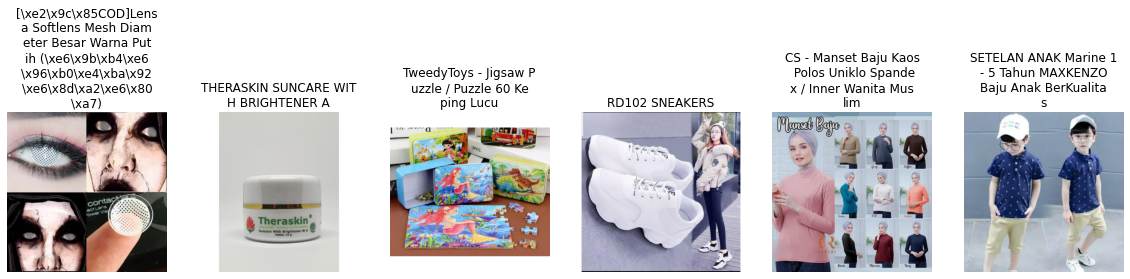

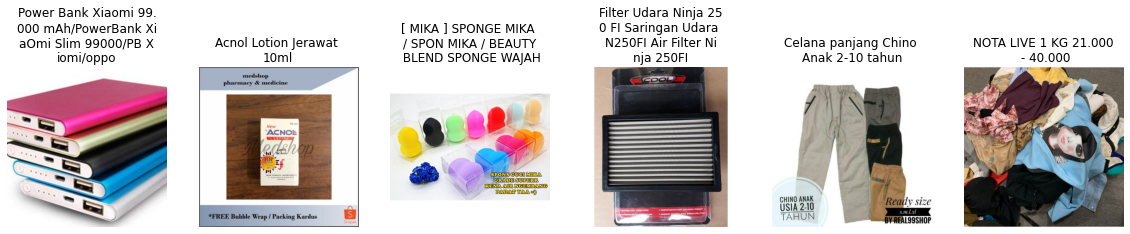

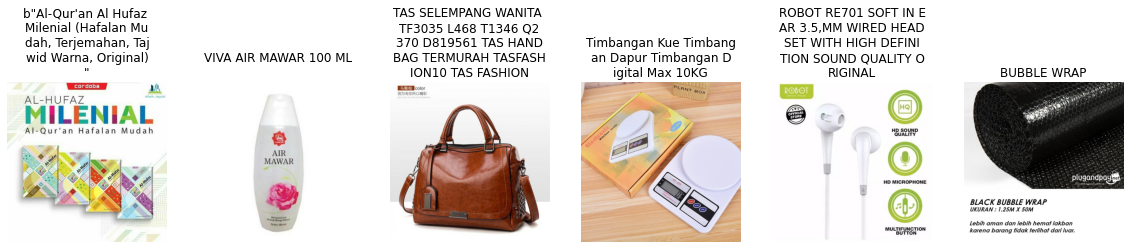

time: 2.87 s (started: 2021-03-21 12:37:09 +00:00)


In [11]:
BASE = '../input/shopee-product-matching/train_images/'

def displayDF(train, random=False, COLS=6, ROWS=4, path=BASE):
    for k in range(ROWS):
        plt.figure(figsize=(20,5))
        for j in range(COLS):
            if random: row = np.random.randint(0,len(train))
            else: row = COLS*k + j
            name = train.iloc[row,1]
            title = train.iloc[row,3]
            title_with_return = ""
            for i,ch in enumerate(title):
                title_with_return += ch
                if (i!=0)&(i%20==0): title_with_return += '\n'
            img = cv2.imread(path+name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1,COLS,j+1)
            plt.title(title_with_return)
            plt.axis('off')
            plt.imshow(img)
        plt.show()
        
displayDF(train, random=True)


## Compute Baseline CV Score
`image_phash` ベースでグループしたものをベースラインとして計算

In [12]:
tmp = train.groupby("image_phash").posting_id.agg("unique").to_dict()
train["oof"] = train.image_phash.map(tmp)


time: 1.83 s (started: 2021-03-21 12:37:12 +00:00)


In [13]:
def getMetric(col):
    def f1score(row):
        n = len(np.intersect1d(row.target, row[col]))
        return 2 * n / (len(row.target) + len(row[col]))
    return f1score

train["f1"] = train.apply(getMetric("oof"), axis=1)
print("Baseline score =", train.f1.mean())

Baseline score = 0.5530933399167943
time: 1.67 s (started: 2021-03-21 12:37:14 +00:00)


## Compute RAPIDS Model CV and Infer Submission


In [14]:
if COMPUTE_CV:
    test = pd.read_csv('../input/shopee-product-matching/train.csv')
    test_gf = cudf.DataFrame(test)
    print('Using train as test to compute CV (since commit notebook). Shape is', test_gf.shape )
else:
    test = pd.read_csv('../input/shopee-product-matching/test.csv')
    test_gf = cudf.read_csv('../input/shopee-product-matching/test.csv')
    print('Test shape is', test_gf.shape )
test_gf.head()

Using train as test to compute CV (since commit notebook). Shape is (34250, 5)


,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


time: 128 ms (started: 2021-03-21 12:37:16 +00:00)


### Image Embeddings

In [15]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=256, batch_size=32, path=''): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange( len(self.df) )
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(( (len(self.df)) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes),self.img_size,self.img_size,3),dtype='float32')
        df = self.df.iloc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            img = cv2.imread(self.path+row.image)
            X[i,] = cv2.resize(img,(self.img_size,self.img_size)) #/128.0 - 1.0
        return X

time: 15.5 ms (started: 2021-03-21 12:37:16 +00:00)


In [16]:
BASE = '../input/shopee-product-matching/test_images/'
if COMPUTE_CV: BASE = '../input/shopee-product-matching/train_images/'

# WGT = '../input/effnetb0/efficientnetb0_notop.h5'

model = EfficientNetB0(weights="imagenet",include_top=False, pooling='avg', input_shape=None)

embeds = []
CHUNK = 1024*4

print('Computing image embeddings...')
CTS = len(test)//CHUNK
if len(test) % CHUNK != 0: CTS += 1
for i,j in enumerate(range(CTS)):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(test))
    print('chunk',a,'to',b)
    
    test_gen = DataGenerator(test.iloc[a:b], batch_size=32, path=BASE)
    image_embeddings = model.predict(test_gen,verbose=1,use_multiprocessing=True, workers=4)
    embeds.append(image_embeddings)

    #if i>=1: break
    
_ = gc.collect()
image_embeddings = np.concatenate(embeds)
print('image embeddings shape',image_embeddings.shape)

assert image_embeddings.shape[0] == test.shape[0]
del model, embeds


16711680/16705208 [==============================] - 0s 0us/step
Computing image embeddings...
chunk 0 to 4096
128/128 [==============================] - 47s 229ms/step
chunk 4096 to 8192
128/128 [==============================] - 33s 247ms/step
chunk 8192 to 12288
128/128 [==============================] - 33s 245ms/step
chunk 12288 to 16384
128/128 [==============================] - 32s 241ms/step
chunk 16384 to 20480
128/128 [==============================] - 32s 242ms/step
chunk 20480 to 24576
128/128 [==============================] - 32s 243ms/step
chunk 24576 to 28672
128/128 [==============================] - 32s 243ms/step
chunk 28672 to 32768
128/128 [==============================] - 32s 240ms/step
chunk 32768 to 34250
47/47 [==============================] - 12s 234ms/step
image embeddings shape (34250, 1280)
time: 4min 53s (started: 2021-03-21 12:37:16 +00:00)


### Text Embeddings

In [19]:
print("Compute text embeddings ...")
model = TfidfVectorizer(stop_words="english", binary=True, max_features=25_000)
text_embeddings = model.fit_transform(test_gf.title).toarray()
print("text embeddings shape", text_embeddings.shape)

assert test.shape[0] == text_embeddings.shape[0]


Compute text embeddings ...
text embeddings shape (34250, 24939)
time: 16 s (started: 2021-03-21 12:42:21 +00:00)


## PHash based predictions


In [43]:
mp = test.groupby('image_phash').posting_id.agg('unique').to_dict()
test['preds_image_phash'] = test.image_phash.map(tmp)
test.head()

,posting_id,image,image_phash,title,label_group,preds_img_emb,preds_text_emb,target,oof,f1_oof,f1_img_emb,f1_text_emb,preds_image_phash,preds
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,[train_129225211],"[train_129225211, train_2278313361]","[train_129225211, train_2278313361]","[train_129225211, train_2278313361]",1.000000,0.666667,1.000000,[train_129225211],"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080, train_183...","[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080]",1.000000,1.000000,0.666667,[train_3386243561],[train_3386243561]
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,[train_2288590299],"[train_2288590299, train_3803689425]","[train_2288590299, train_3803689425]",[train_2288590299],0.666667,0.666667,0.666667,[train_2288590299],[train_2288590299]
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,[train_2406599165],"[train_2406599165, train_3576714541, train_150...","[train_2406599165, train_3342059966]","[train_1508100548, train_1744956981, train_240...",0.285714,0.666667,0.285714,[train_2406599165],"[train_2406599165, train_3576714541, train_174..."
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",[train_3369186413],"[train_3369186413, train_921438619]","[train_3369186413, train_921438619]",1.000000,1.000000,0.666667,[train_3369186413],[train_3369186413]


time: 1.72 s (started: 2021-03-21 14:44:03 +00:00)


In [35]:
KNN = 50
if len(test)==3: KNN = 2
model = NearestNeighbors(n_neighbors=KNN)
model.fit(image_embeddings)


def calc_image_embedding_metrics(x):

    preds = []
    CHUNK = 1024*4
    print('Finding similar images...')
    CTS = len(image_embeddings)//CHUNK
    if len(image_embeddings)%CHUNK!=0: CTS += 1
    for j in range( CTS ):
        
        a = j*CHUNK
        b = (j+1)*CHUNK
        b = min(b,len(image_embeddings))
        print('chunk',a,'to',b)
        distances, indices = model.kneighbors(image_embeddings[a:b,])
        
        for k in range(b-a):
            IDX = np.where(distances[k,] < x)[0]
            IDS = indices[k,IDX]
            o = test.iloc[IDS].posting_id.values
            preds.append(o)
    
    test["preds"] = preds
    f1_scores = test.apply(getMetric("preds"), axis=1) 

    return (1 - f1_scores.mean())


def objective(trial):
    x = trial.suggest_uniform("x", 3, 15)
    return calc_image_embedding_metrics(x)


study_image = optuna.create_study()
study_image.optimize(objective, n_trials=10)
print(f"Optimized image embedding knn threshold = {study_image.best_params}, f1 score = {1 - study_image.best_value}")


[I 2021-03-21 14:23:37,263] A new study created in memory with name: no-name-22971646-efdc-4e00-ac94-1aeab6eda4c9


Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:23:50,711] Trial 0 finished with value: 0.3581102959677842 and parameters: {'x': 6.184392919690923}. Best is trial 0 with value: 0.3581102959677842.


Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:24:05,057] Trial 1 finished with value: 0.5094499404139186 and parameters: {'x': 10.499138809017854}. Best is trial 0 with value: 0.3581102959677842.


Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:24:20,979] Trial 2 finished with value: 0.8417136432893826 and parameters: {'x': 14.560814523184105}. Best is trial 0 with value: 0.3581102959677842.


Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:24:34,430] Trial 3 finished with value: 0.35798297858580796 and parameters: {'x': 6.190810227611928}. Best is trial 3 with value: 0.35798297858580796.


Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:24:49,896] Trial 4 finished with value: 0.7047527434259306 and parameters: {'x': 12.516546606317188}. Best is trial 3 with value: 0.35798297858580796.


Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:25:03,589] Trial 5 finished with value: 0.3646096996388798 and parameters: {'x': 5.699033588172618}. Best is trial 3 with value: 0.35798297858580796.


Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:25:18,506] Trial 6 finished with value: 0.45672516225980353 and parameters: {'x': 9.817101868397337}. Best is trial 3 with value: 0.35798297858580796.


Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:25:33,879] Trial 7 finished with value: 0.7069275926480245 and parameters: {'x': 12.537020888205792}. Best is trial 3 with value: 0.35798297858580796.


Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:25:47,325] Trial 8 finished with value: 0.36703075829218335 and parameters: {'x': 5.53830314554557}. Best is trial 3 with value: 0.35798297858580796.


Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:26:01,091] Trial 9 finished with value: 0.3597262164835051 and parameters: {'x': 6.066746318630152}. Best is trial 3 with value: 0.35798297858580796.


Optimized image embedding knn threshold = {'x': 4.412605907724213}, f1 score = 0.6129148655925446
time: 2min 23s (started: 2021-03-21 14:23:37 +00:00)


In [36]:
def calc_text_embedding_metrics(x):
    print('Finding similar titles...')
    preds = []
    CTS = len(test)//CHUNK
    if len(test)%CHUNK!=0: CTS += 1
    for j in range( CTS ):
        
        a = j*CHUNK
        b = (j+1)*CHUNK
        b = min(b,len(test))
        print('chunk',a,'to',b)
        
        # COSINE SIMILARITY DISTANCE
        cts = cupy.matmul(text_embeddings, text_embeddings[a:b].T).T
        
        for k in range(b-a):
            IDX = cupy.where(cts[k,] > x)[0]
            o = test.iloc[cupy.asnumpy(IDX)].posting_id.values
            preds.append(o)

    test["preds"] = preds
    f1_scores = test.apply(getMetric('preds'), axis=1)        

    return (1 - f1_scores.mean())


def objective(trial):
    x = trial.suggest_uniform("x", 0.5, 1.0)
    return calc_text_embedding_metrics(x)


study_text = optuna.create_study()
study_text.optimize(objective, n_trials=15)

print(f"Optimized text embedding cts threshold = {study_text.best_params}, f1 score = {1 - study_text.best_value}")


[I 2021-03-21 14:26:01,121] A new study created in memory with name: no-name-fda24b82-5b11-4954-ac31-488f1b862ac8


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:26:32,922] Trial 0 finished with value: 0.3877213425588123 and parameters: {'x': 0.7035765626309332}. Best is trial 0 with value: 0.3877213425588123.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:27:04,574] Trial 1 finished with value: 0.506085413506134 and parameters: {'x': 0.9786859038391966}. Best is trial 0 with value: 0.3877213425588123.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:27:36,340] Trial 2 finished with value: 0.3443324291335551 and parameters: {'x': 0.5811470918602475}. Best is trial 2 with value: 0.3443324291335551.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:28:08,313] Trial 3 finished with value: 0.35520553599142024 and parameters: {'x': 0.6221064110345687}. Best is trial 2 with value: 0.3443324291335551.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:28:40,783] Trial 4 finished with value: 0.48902667079018114 and parameters: {'x': 0.9207179060802508}. Best is trial 2 with value: 0.3443324291335551.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:29:12,512] Trial 5 finished with value: 0.3663369273809973 and parameters: {'x': 0.6516962553846362}. Best is trial 2 with value: 0.3443324291335551.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:29:44,599] Trial 6 finished with value: 0.33961742839290365 and parameters: {'x': 0.5187031862812939}. Best is trial 6 with value: 0.33961742839290365.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:30:16,338] Trial 7 finished with value: 0.37846252162670957 and parameters: {'x': 0.6809121266810405}. Best is trial 6 with value: 0.33961742839290365.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:30:48,184] Trial 8 finished with value: 0.3902703606897443 and parameters: {'x': 0.7084793541562615}. Best is trial 6 with value: 0.33961742839290365.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:31:19,994] Trial 9 finished with value: 0.33932668104906993 and parameters: {'x': 0.5379109548718829}. Best is trial 9 with value: 0.33932668104906993.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:31:51,683] Trial 10 finished with value: 0.4486455028327374 and parameters: {'x': 0.8334365394831362}. Best is trial 9 with value: 0.33932668104906993.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:32:23,692] Trial 11 finished with value: 0.34087511669912085 and parameters: {'x': 0.5021432682492467}. Best is trial 9 with value: 0.33932668104906993.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:32:55,899] Trial 12 finished with value: 0.3395430383302236 and parameters: {'x': 0.5143943941811089}. Best is trial 9 with value: 0.33932668104906993.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:33:28,076] Trial 13 finished with value: 0.3398042008236416 and parameters: {'x': 0.5530497019295001}. Best is trial 9 with value: 0.33932668104906993.


Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


[I 2021-03-21 14:34:00,554] Trial 14 finished with value: 0.4324368020886883 and parameters: {'x': 0.7998155610721812}. Best is trial 9 with value: 0.33932668104906993.


Optimized text embedding cts threshold = {'x': 4.412605907724213}, f1 score = 0.6129148655925446
time: 7min 59s (started: 2021-03-21 14:26:01 +00:00)


In [40]:
KNN = 50
if len(test)==3: KNN = 2
model = NearestNeighbors(n_neighbors=KNN)
model.fit(image_embeddings)

dist_th = 6.0
preds = []
CHUNK = 1024*4
print('Finding similar images...')
CTS = len(image_embeddings)//CHUNK
if len(image_embeddings)%CHUNK!=0: CTS += 1
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(image_embeddings))
    print('chunk',a,'to',b)
    distances, indices = model.kneighbors(image_embeddings[a:b,])
    
    for k in range(b-a):
        IDX = np.where(distances[k,] < dist_th)[0]
        IDS = indices[k,IDX]
        o = test.iloc[IDS].posting_id.values
        preds.append(o)

test["preds_img_emb"] = preds       
del model, distances, indices, preds
_ = gc.collect()

Finding similar images...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250
time: 12.7 s (started: 2021-03-21 14:41:01 +00:00)


In [42]:
preds = []
CHUNK = 1024*4
sim_th = 0.55

print('Finding similar titles...')
CTS = len(test)//CHUNK
if len(test)%CHUNK!=0: CTS += 1
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(test))
    print('chunk',a,'to',b)
    
    # COSINE SIMILARITY DISTANCE
    cts = cupy.matmul(text_embeddings, text_embeddings[a:b].T).T
    
    for k in range(b-a):
        IDX = cupy.where(cts[k,] > sim_th)[0]
        o = test.iloc[cupy.asnumpy(IDX)].posting_id.values
        preds.append(o)
        
_ = gc.collect()
test['preds_text_emb'] = preds
test.head()

Finding similar titles...
chunk 0 to 4096
chunk 4096 to 8192
chunk 8192 to 12288
chunk 12288 to 16384
chunk 16384 to 20480
chunk 20480 to 24576
chunk 24576 to 28672
chunk 28672 to 32768
chunk 32768 to 34250


,posting_id,image,image_phash,title,label_group,preds_img_emb,preds_text_emb,target,oof,f1_oof,f1_img_emb,f1_text_emb,preds_image_phash,preds
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,[train_129225211],"[train_129225211, train_2278313361]","[train_129225211, train_2278313361]","[train_129225211, train_2278313361]",1.000000,0.666667,1.000000,[train_129225211],"[train_129225211, train_2278313361]"
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,"[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080, train_183...","[train_3386243561, train_3423213080]","[train_3386243561, train_3423213080]",1.000000,1.000000,0.666667,[train_3386243561],[train_3386243561]
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,[train_2288590299],"[train_2288590299, train_3803689425]","[train_2288590299, train_3803689425]",[train_2288590299],0.666667,0.666667,0.666667,[train_2288590299],[train_2288590299]
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,[train_2406599165],"[train_2406599165, train_3576714541, train_150...","[train_2406599165, train_3342059966]","[train_1508100548, train_1744956981, train_240...",0.285714,0.666667,0.285714,[train_2406599165],"[train_2406599165, train_3576714541, train_174..."
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,"[train_3369186413, train_921438619]",[train_3369186413],"[train_3369186413, train_921438619]","[train_3369186413, train_921438619]",1.000000,1.000000,0.666667,[train_3369186413],[train_3369186413]


time: 31.4 s (started: 2021-03-21 14:42:05 +00:00)


In [44]:
def combine_for_sub(row):
    x = np.concatenate([row.preds_img_emb, row.preds_text_emb, row.preds_image_phash])
    return ' '.join(np.unique(x))


def combine_for_cv(row):
    x = np.concatenate([row.preds_img_emb, row.preds_text_emb, row.preds_image_phash])
    return np.unique(x)


time: 2.85 ms (started: 2021-03-21 14:44:29 +00:00)


In [45]:
if COMPUTE_CV:
    tmp = test.groupby('label_group').posting_id.agg('unique').to_dict()
    test['target'] = test.label_group.map(tmp)
    test['oof'] = test.apply(combine_for_cv,axis=1)
    test['f1_oof'] = test.apply(getMetric('oof'), axis=1)
    test['f1_img_emb'] = test.apply(getMetric('preds_img_emb'), axis=1)
    test['f1_text_emb'] = test.apply(getMetric('preds_text_emb'), axis=1)
 
    print("CV Score oof =", test.f1_oof.mean())
    print('CV Score image =', test.f1_img_emb.mean())
    print('CV Score text =', test.f1_text_emb.mean())


CV Score oof = 0.7324054042120052
CV Score image = 0.6393196101848189
CV Score text = 0.6603892071625337
time: 7.05 s (started: 2021-03-21 14:44:31 +00:00)
